# Fitting growth equation(s) to data from Bas

Original parameters score:51936.22598149154


100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [40:31<00:00, 411.32it/s]


[3.64310138e+03 3.78413256e+03 4.13951998e+03 ... 1.12497154e+08
 1.12512607e+08 1.12751844e+08]
Best score: 3643.1013815886727
Best parameters: [ 0.5212435  10.41064018  0.33368693  4.26537504]


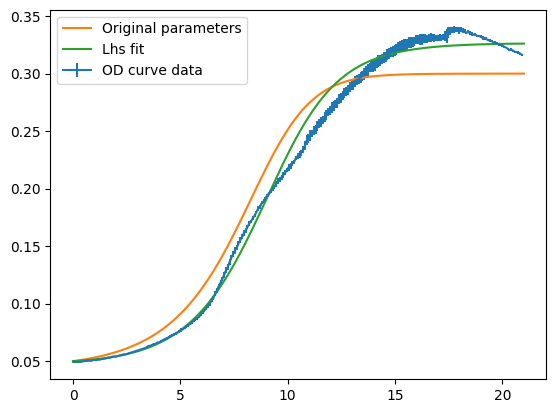

In [29]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm
from pyDOE import lhs

#Define our color pallette
colors = {'Orange': np.array([251,166,73], dtype='int')/255, "Turquoise": np.array([69,196,175], dtype='int')/255, "Red": np.array([236,108,95], dtype='int')/255, "Green": np.array([76,139,48], dtype='int')/255, "Purple": np.array([100,25,120], dtype='int')/255}
#Custom color cycle
from cycler import cycler
color_list = np.array([np.array([251,166,73], dtype='int'),np.array([69,196,175], dtype='int'),np.array([236,108,95], dtype='int'),
                       np.array([76,139,48], dtype='int'),np.array([100,25,120], dtype='int'),np.array([249, 207, 202], dtype='int'),
                       np.array([254, 226, 195], dtype='int'),np.array([196, 217, 187], dtype='int'),np.array([194, 236, 229], dtype='int'),
                       np.array([204, 179, 210], dtype='int')])/255
custom_cycler = (cycler(color=color_list, linewidth=[2,2,2,2,2,2,2,2,2,2]))
print(f"Current available colors={len(color_list)}")

#Define standard text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Dashed line style
dashline = (1, (3, 3))

OD_data = pd.read_csv("Data/15mMSuccinate_aerobic_OD_processed.csv", header=0)
OD_error = pd.read_csv("Data/15mMSuccinate_aerobic_OD_std_processed.csv", header=0)

time = OD_data.iloc[0:,0].to_numpy()
OD_data = OD_data.iloc[0:,6].to_numpy()
OD_error = OD_error.iloc[0:,6]
#Replace any zero values with the mean error.
# OD_error_fit = OD_error.replace(0, 1)

# #Delete the problematic sets.
# replace_index = np.where(OD_error_fit < 10e-6)[0]
# print(replace_index)
# OD_error_fit[replace_index] = 1

def deriv(y, t, p):
    Cx = y
    mumax, tc, cap, sigma = p
    mu = mumax*np.exp(-0.5*((t-tc)/sigma)**2)*(1-Cx/cap)
    
    d_Cx_dt = Cx*mu
    
    return d_Cx_dt

def simulateODE(parameters, x_init, t_end = 18, Nsteps=200):
    """
    Simulates the ODE's with the given parameters.
    """
    # Make a numpy array with the time steps for which you want output
    timepoints = np.linspace(0, t_end, Nsteps)
    # Calculate state variables at requested time points
    x_t = odeint(deriv, x_init, timepoints, args = (parameters,))

    # Return time points and state variables at those time points
    # This technically combines both variables into a tuple which can be unpacked after calling the function
    return timepoints, x_t

def calculate_score(sim_time, sim, data, error):
    """
    Scoring function for a single data-series.
    time can also be interpreted as another x-axis.
    """
    #Check if there are any zero's or almost zero values and replace by 1
    error = error.replace(0,1)
    replace_index = np.where(error < 10e-6)[0]
    error[replace_index] = 1
    #Change the shape of the simulated data to the same amount of datapoints
    if (len(sim) != len(data)):
        sim_interp = interpolate.interp1d(sim_time, sim)
        sim = sim_interp(time.tolist())
        
    difference = (sim-data)**2
    variance = error**2
    scores = difference/variance

    # for i in range(len(scores)):
    #     print(f"Timepoint: {time[i]} - Simulation: {sim[i]} - Data: {data[i]} - Variance: {error[i]} - Score: {scores[i]}")
    
    score = np.sum(scores)
    
    return score
    
def optimize(p):
    x_init = 0.05

    _time, _output = simulateODE(p, x_init, 21, 200)
    #Somehow it outputs a 2d list of lists (Makes sense but not with only one state variable)
    _output = np.array(_output).squeeze()
    opt_score = score(_time, _output, OD_data, OD_error)
    
    return opt_score

#Define parameters
mumax = 0.8558
tc = 13.8
cap = 0.3
sigma = 6
params = [mumax, tc, cap, sigma]

simtime, org_output = simulateODE(params, 0.05, 21, 200)
simtime += time[0]
org_output = np.array(org_output).squeeze()

print(f"Original parameters score:{calculate_score(simtime, org_output, OD_data, OD_error)}")

lower = np.array([0.1,0.1,0.1,0.1])
upper = np.array([2,20,1,20])

sample = lhs(4, 1000000)
# Now, for each row/parameter in the sample matrix, we need to re-scale these using the bounds
for i in range(0, len(upper)):
    sample[:,i] = lower[i] + (upper[i]-lower[i])*sample[:,i]
    
#Simulate the sampled sets
scores = np.zeros(len(sample))
outputs = np.zeros((len(sample),200))
bestscore = calculate_score(simtime, org_output, OD_data, OD_error)

for i in tqdm(range(len(sample))):
    simtime, output = simulateODE(sample[i], 0.05, 21, 200)
    output = np.array(output).squeeze()
    score = calculate_score(simtime, output, OD_data, OD_error)
    scores[i] = score
    outputs[i] = output
#Sort scores
index = scores.argsort()
sample = sample[index]
scores = scores[index]
outputs = outputs[index]

print(scores)
print(f"Best score: {scores[0]}")
print(f"Best parameters: {sample[0]}")

plt.errorbar(time, OD_data, yerr=OD_error, label="OD curve data")
plt.plot(simtime, org_output, label="Original parameters")
plt.plot(simtime, outputs[0], label="Lhs fit")
plt.legend()
plt.show()

In [30]:
# Best parameters: [ 0.5212435  10.41064018  0.33368693  4.26537504]